# [AlexNet]

*KU LeeDongGyu*

### Contents

1. Almost Original Alexnet
2. My Alexnet
```
1) Size = 64,
2) Size = 48,
```
3. Size = 48, No Early Stopping
```
1) Epoch = 50
2) Epoch = 100
```

### Install Packages

### Module

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Colab Notebooks/project

/content/drive/My Drive/Colab Notebooks/project


In [0]:
import sys

In [0]:
# 모듈로 받을 경로 확인
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/Colab Notebooks/project']

In [0]:
# 내 노트북이 아닌, 전산실 컴퓨터의 colab에서 돌렸으므로, 다시돌리려면 경로 수정할것!
sys.path.append("/content/drive/My Drive/Colab Notebooks/project")

In [0]:
from lrn import LRN #만든 모듈, class
from f1score import macro_f1score, weighted_f1score
from pool_helper import PoolHelper

In [0]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape, Lambda, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger,Callback
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/project'

In [0]:
# Alexnet을 개조
# Data Augmentation은 컴퓨터 성능의 한계로 못하기 때문에 변형함.

# 주의 !!!!기본은 모형을 조절하는 것이 아닌, 데이터를 뻥튀기 하는 것임을 늘 잊지말기!!!!

# data import
x_train = pd.read_csv("mydata/X_train.csv",header=0,index_col=0)
x_valid = pd.read_csv("mydata/X_private_test.csv",header=0,index_col=0)
x_test = pd.read_csv("mydata/X_public_test.csv",header=0,index_col=0)
y_train = pd.read_csv("mydata/y_train.csv",header=0,index_col=0)
y_valid = pd.read_csv("mydata/y_private_test.csv",header=0,index_col=0)
y_test = pd.read_csv("mydata/y_public_test.csv",header=0,index_col=0)

In [0]:
# data handling
x_train = np.array(x_train).reshape([-1,48,48,3]) 
x_valid = np.array(x_valid).reshape([-1,48,48,3]) 
x_test = np.array(x_test).reshape([-1,48,48,3]) 

y_train=to_categorical(y_train) # one hot encoding
y_valid=to_categorical(y_valid)
y_test=to_categorical(y_test)

In [0]:
# data handling
size = 64 #적당한 크기로 잡음.
x_train = np.array(x_train).reshape([-1,48,48,3])

In [0]:
x_train_zoom = np.zeros([x_train.shape[0],size,size,3],dtype="float32")

for i in range(x_train.shape[0]):
    x_train_zoom[i,:] = cv2.resize(x_train[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) /255

In [0]:
x_train = x_train / 255 

In [0]:
x_valid = np.array(x_valid).reshape([-1,48,48,3])
x_valid_zoom = np.zeros([x_valid.shape[0],size,size,3],dtype="float32")
for i in range(x_valid.shape[0]):
    x_valid_zoom[i,:] = cv2.resize(x_valid[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) /255

In [0]:
 x_valid = x_valid / 255

In [0]:
x_test = np.array(x_test).reshape([-1,48,48,3])
x_test_zoom = np.zeros([x_test.shape[0],size,size,3],dtype="float32")
for i in range(x_test.shape[0]):
    x_test_zoom[i,:] = cv2.resize(x_test[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) /255

In [0]:
x_test = x_test / 255

## 1. My Alexnet

#### 1) Size = 64

In [0]:
# 다음의 절차로 모형을 개조한다.

# 1. 227의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. 모수와 관련이 가장 깊은 fc층에서, 기존의 4096개의 노드를 1/16 (비율) 배 만큼, 즉 256개로줄인다.
# 3. 다음과 같이 모형을 재구성한다.

# convolution layer
# 입력 : 64x64x1
# 첫번째 층 : 5x5 필터 24장, strides = 2 -> maxpooling 3x3 , stirdes = 2   ===> 14 x 14 x 24 feature map
# 두번째 층 : 3x3 필터 64장, strides = 1, padding = "same"                 ===> 14 x 14 x 64 feature map
# 세번째 층 : 3x3 필터 96장, strides = 1                                   ===> 12 x 12 x 96 feature map
# 네번째 층 : 3x3 필터 96장, strides = 1, padding = "same"                 ===> 12 x 12 x 96 feature map
# 다섯째 층 : 3x3 필터 64장, strides = 1 -> maxpooling 3x3 , strides = 2   ===> 4 x 4 x 64 feature map

# fc layer
# 여섯째 층 : 노드 256개, dropout = 0.5
# 일곱째 층 : 노드 256개, dropout = 0.5
# 여덟째 층 : 노드 7개



def Alexnet(img_shape=(64, 64, 3), n_classes=7, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(24, (5, 5), input_shape=img_shape, strides=2,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer1_LRN'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=2))

	# Layer 2
	alexnet.add(Conv2D(64, (3, 3), padding='same',strides=1,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer2_LRN'))

	# Layer 3
	alexnet.add(Conv2D(96, (3, 3),  strides=1,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer3_LRN'))

	# Layer 4
	alexnet.add(Conv2D(96, (3, 3), padding='same'))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer4_LRN'))

	# Layer 5
	alexnet.add(Conv2D(64, (3, 3)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer5_LRN'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=2))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(256,kernel_regularizer=l2(l2_reg)))

	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(256,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [0]:
#내 데이터 맞춤형 모형
model = Alexnet(img_shape=(64, 64, 3), n_classes=7, l2_reg=0.,weights=None)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 24)        1824      
_________________________________________________________________
activation_18 (Activation)   (None, 30, 30, 24)        0         
_________________________________________________________________
layer1_LRN (LRN)             (None, 30, 30, 24)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        13888     
_________________________________________________________________
activation_19 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
layer2_LRN (LRN)             (None, 14, 14, 64)       

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4,verbose=1,mode='min')

In [0]:
# early stopping 
history =  model.fit(x_train_zoom,y_train,batch_size=64, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 5s 22ms/step - loss: 1.8260 - accuracy: 0.2438 - macro_f1score: 7.2562e-05 - weighted_f1score: 1.7574e-05 - val_loss: 1.8154 - val_accuracy: 0.2449 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Epoch 2/100
225/225 [==============================] - 5s 20ms/step - loss: 1.7999 - accuracy: 0.2540 - macro_f1score: 0.0095 - weighted_f1score: 0.0024 - val_loss: 1.7294 - val_accuracy: 0.2937 - val_macro_f1score: 0.0661 - val_weighted_f1score: 0.0168
Epoch 3/100
225/225 [==============================] - 5s 20ms/step - loss: 1.6747 - accuracy: 0.3258 - macro_f1score: 0.0741 - weighted_f1score: 0.0177 - val_loss: 1.6071 - val_accuracy: 0.3828 - val_macro_f1score: 0.1224 - val_weighted_f1score: 0.0265
Epoch 4/100
225/225 [==============================] - 5s 20ms/step - loss: 1.5182 - accuracy: 0.4048 - macro_f1score: 0.1518 - weighted_f1score: 0.0293 - val_loss: 1.4848 - val_accuracy: 0.4182 - val_macro_f1score: 0.1521

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

29/29 [==============================] - 0s 9ms/step - loss: 1.2397 - accuracy: 0.5446 - macro_f1score: 0.4102 - weighted_f1score: 0.0682

Accuracy: 0.5446, Macro F1 Score: 0.4102, Weighted F1 Score: 0.0682


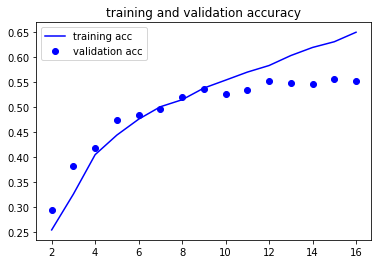

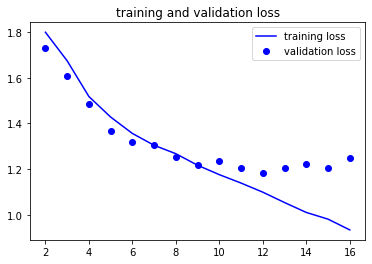

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

#### 2) Size = 48

In [0]:
# 다음의 절차로 모형을 개조한다.

# 1. 227의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. 모수와 관련이 가장 깊은 fc층에서, 기존의 4096개의 노드를 1/16 (비율) 배 만큼, 즉 256개로줄인다.
# 3. 다음과 같이 모형을 재구성한다.

# convolution layer
# 입력 : 64x64x1
# 첫번째 층 : 5x5 필터 24장, strides = 2 -> maxpooling 3x3 , stirdes = 2   ===> 10 x 10 x 24 feature map
# 두번째 층 : 3x3 필터 64장, strides = 1, padding = "same"                 ===> 14 x 14 x 64 feature map
# 세번째 층 : 3x3 필터 96장, strides = 1                                   ===> 12 x 12 x 96 feature map
# 네번째 층 : 3x3 필터 96장, strides = 1, padding = "same"                 ===> 12 x 12 x 96 feature map
# 다섯째 층 : 3x3 필터 64장, strides = 1 -> maxpooling 3x3 , strides = 2   ===> 4 x 4 x 64 feature map

# fc layer
# 여섯째 층 : 노드 256개, dropout = 0.5
# 일곱째 층 : 노드 256개, dropout = 0.5
# 여덟째 층 : 노드 7개



def Alexnet(img_shape=(48, 48, 3), n_classes=7, l2_reg=0., weights=None):

	# Initialize model
	alexnet = Sequential()


	# Layer 1
	alexnet.add(Conv2D(24, (5, 5), input_shape=img_shape, strides=2,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer1_LRN'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=2))

	# Layer 2
	alexnet.add(Conv2D(64, (3, 3), padding='same',strides=1,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer2_LRN'))

	# Layer 3
	alexnet.add(Conv2D(96, (3, 3),  strides=1,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer3_LRN'))

	# Layer 4
	alexnet.add(Conv2D(96, (3, 3), padding='same'))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer4_LRN'))

	# Layer 5
	alexnet.add(Conv2D(64, (3, 3)))
	alexnet.add(Activation('relu'))
	alexnet.add(LRN(name='layer5_LRN'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=2))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(256,kernel_regularizer=l2(l2_reg)))

	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(256,kernel_regularizer=l2(l2_reg)))
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [0]:
#내 데이터 맞춤형 모형
model = Alexnet(img_shape=(48, 48, 3), n_classes=7, l2_reg=0.,weights=None)

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 22, 22, 24)        1824      
_________________________________________________________________
activation_26 (Activation)   (None, 22, 22, 24)        0         
_________________________________________________________________
layer1_LRN (LRN)             (None, 22, 22, 24)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 24)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        13888     
_________________________________________________________________
activation_27 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
layer2_LRN (LRN)             (None, 10, 10, 64)       

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4,verbose=1,mode='min')

In [0]:
# early stopping 
history = model.fit(x_train,y_train,batch_size=64, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 4s 16ms/step - loss: 1.8195 - accuracy: 0.2487 - macro_f1score: 8.1799e-04 - weighted_f1score: 1.0206e-04 - val_loss: 1.7516 - val_accuracy: 0.2758 - val_macro_f1score: 0.0163 - val_weighted_f1score: 0.0018
Epoch 2/100
225/225 [==============================] - 3s 13ms/step - loss: 1.6545 - accuracy: 0.3366 - macro_f1score: 0.0869 - weighted_f1score: 0.0149 - val_loss: 1.5207 - val_accuracy: 0.4126 - val_macro_f1score: 0.1498 - val_weighted_f1score: 0.0283
Epoch 3/100
225/225 [==============================] - 3s 13ms/step - loss: 1.5094 - accuracy: 0.4134 - macro_f1score: 0.1600 - weighted_f1score: 0.0299 - val_loss: 1.4285 - val_accuracy: 0.4494 - val_macro_f1score: 0.1703 - val_weighted_f1score: 0.0315
Epoch 4/100
225/225 [==============================] - 3s 13ms/step - loss: 1.4111 - accuracy: 0.4581 - macro_f1score: 0.2027 - weighted_f1score: 0.0374 - val_loss: 1.3676 - val_accuracy: 0.4795 - val_macro_f1score: 0.2012 - val_w

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

29/29 [==============================] - 0s 6ms/step - loss: 1.3570 - accuracy: 0.5332 - macro_f1score: 0.4054 - weighted_f1score: 0.0681

Accuracy: 0.5332, Macro F1 Score: 0.4054, Weighted F1 Score: 0.0681


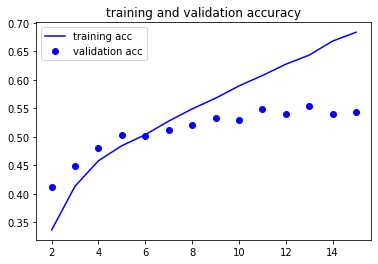

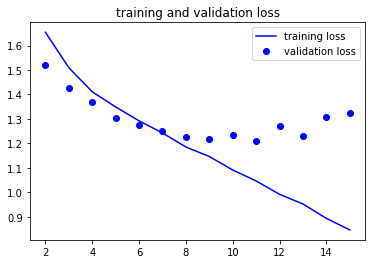

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# 2. VGG. For Size = 64,
---

### 1) My VGG11 (Pretraining)

In [0]:
# 논문에서 VGG19 의 FC층은 VGG11로 pretraining하여 얻은 초기치로 설정하였음.
# 기존의 VGG11을 개조
# Data Augmentation은 컴퓨터 성능의 한계로 못하기 때문에 변형함.

# 주의 !!!!기본은 모형을 조절하는 것이 아닌, 데이터를 뻥튀기 하는 것임을 늘 잊지말기!!!!

# 다음의 절차로 모형을 개조한다.

# 1. 224의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. 모수와 관련이 가장 깊은 fc층에서, 기존의 4096개의 노드를 1/16 (비율) 배 만큼, 즉 256개로줄인다.
# 3. Conv의 filter는 1/8로 줄인다.
# 4. 다음과 같이 모형을 재구성한다.
# 5. 위의 내용은 앞으로 비교될 모형에서도 공통적으로 작용한다.

def VGG11(input_shape=(64,64,3), classes=7,include_top=True,pooling=None, weights = None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(256, activation='relu',name='fc1')(x)
        x = Dense(256, activation='relu', name='fc2')(x)
        output = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            output = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            output = GlobalMaxPooling2D()(x)

    # Create model.
    model = Model(img_input, output, name='Vgg11_Pretraining')

    if weights is not None:
        model.load_weights(weights)

    return model


In [0]:
#내 데이터 맞춤형 모형
model = VGG11(input_shape=(64, 64, 3), classes=7, include_top=True,pooling=None, weights = None)

In [0]:
model.summary()

Model: "Vgg11_Pretraining"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 8)         224       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 16)        1168      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 16)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 32)        4640      
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 16, 16, 32)  

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')

In [0]:
history = model.fit(x_train_zoom,y_train,batch_size=64, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 2s 11ms/step - loss: 1.8127 - accuracy: 0.2512 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00 - val_loss: 1.7850 - val_accuracy: 0.2374 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Epoch 2/100
225/225 [==============================] - 2s 10ms/step - loss: 1.6733 - accuracy: 0.3240 - macro_f1score: 0.0674 - weighted_f1score: 0.0133 - val_loss: 1.5314 - val_accuracy: 0.4012 - val_macro_f1score: 0.1497 - val_weighted_f1score: 0.0278
Epoch 3/100
225/225 [==============================] - 2s 10ms/step - loss: 1.4919 - accuracy: 0.4153 - macro_f1score: 0.1556 - weighted_f1score: 0.0300 - val_loss: 1.4895 - val_accuracy: 0.4232 - val_macro_f1score: 0.1646 - val_weighted_f1score: 0.0316
Epoch 4/100
225/225 [==============================] - 2s 10ms/step - loss: 1.3900 - accuracy: 0.4596 - macro_f1score: 0.2032 - weighted_f1score: 0.0380 - val_loss: 1.3769 - val_accuracy: 0.4634 - val_macro_f1score: 0.1871

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


29/29 [==============================] - 0s 5ms/step - loss: 1.4477 - accuracy: 0.5323 - macro_f1score: 0.4584 - weighted_f1score: 0.0736

Accuracy: 0.5323, Macro F1 Score: 0.4584, Weighted F1 Score: 0.0736


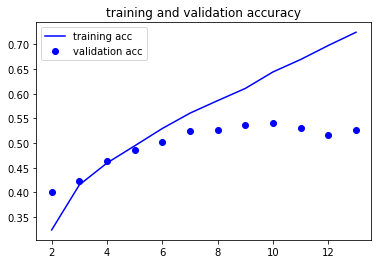

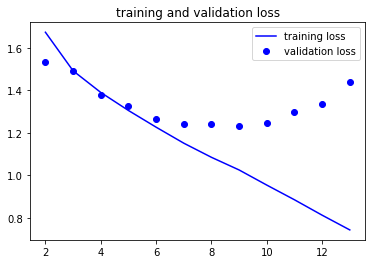

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
# 한층당 W 와 b , 2개씩 있으므로 11개층이라면 22개의 모수 벡터 및 행렬이 출력된다.
W = model.get_weights()

### 2) My VGG16 (Pretrained)

In [0]:
# 1. 224의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. 모수와 관련이 가장 깊은 fc층에서, 기존의 4096개의 노드를 1/16 (비율) 배 만큼, 즉 256개로줄인다.
# 3. Conv의 filter는 1/8로 줄인다.
# 4. 다음과 같이 모형을 재구성한다.
# 5. 위의 내용은 앞으로 비교될 모형에서도 공통적으로 작용한다.


def VGG16(input_shape=(64,64,3), classes=7,include_top=True,pooling=None, weights = None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(256, activation='relu', kernel_initializer= tf.constant_initializer(W[-6]), bias_initializer= tf.constant_initializer(W[-5]) , name='fc1')(x) # 초기값은     tf.constant_initializer     로 한다!!
        x = Dense(256, activation='relu', kernel_initializer= tf.constant_initializer(W[-4]), bias_initializer= tf.constant_initializer(W[-3]) , name='fc2')(x)
        output = Dense(classes, kernel_initializer=tf.constant_initializer(W[-2]) , bias_initializer= tf.constant_initializer(W[-1]) , activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            output = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            output = GlobalMaxPooling2D()(x)

    # Create model.
    model = Model(img_input, output, name='vgg16')

    # Load weights.
    # 내 모형에서는 쓸모없다. 다만, 나중의 혹시모를 참고를 위해 코드는 남겨놓는다.
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,cache_subdir='models',file_hash='cbe5617147190e668d6c5d5026f83318')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,cache_subdir='models',file_hash='253f8cb515780f3b799900260a226db6')

        model.load_weights(weights_path) #경로에 있는 초기치 weights가져오기

    elif weights is not None:
        model.load_weights(weights)

    return model



In [0]:
model = VGG16(input_shape=(64, 64, 3), classes=7, include_top=True,pooling=None, weights = None)

In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 8)         224       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 8)         584       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 16)        1168      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 16)        2320      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 16)        0     

In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')


In [0]:
history = model.fit(x_train_zoom,y_train,batch_size=64, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 3s 15ms/step - loss: 1.8140 - accuracy: 0.2499 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00 - val_loss: 1.8198 - val_accuracy: 0.2449 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Epoch 2/100
225/225 [==============================] - 3s 14ms/step - loss: 1.8115 - accuracy: 0.2514 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00 - val_loss: 1.8168 - val_accuracy: 0.2449 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Epoch 3/100
225/225 [==============================] - 3s 14ms/step - loss: 1.8117 - accuracy: 0.2514 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00 - val_loss: 1.8156 - val_accuracy: 0.2449 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Epoch 4/100
225/225 [==============================] - 3s 14ms/step - loss: 1.8109 - accuracy: 0.2514 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00 - val_loss: 1.8190 - val_accu

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

29/29 [==============================] - 0s 6ms/step - loss: 1.8138 - accuracy: 0.2494 - macro_f1score: 0.0000e+00 - weighted_f1score: 0.0000e+00

Accuracy: 0.2494, Macro F1 Score: 0.0000, Weighted F1 Score: 0.0000


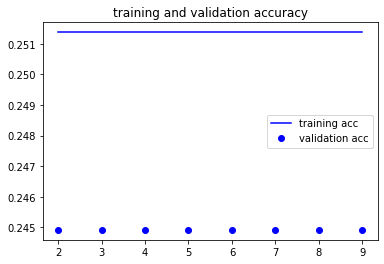

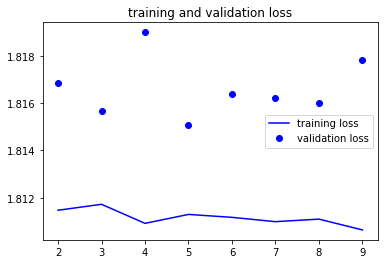

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## 3. For Size =48,
---

### 1) My VGG11 (Pretraining)

In [0]:
# 오리지널 데이터에 대해 다루어본다.

def VGG11(input_shape=(48,48,3), classes=7,include_top=True,pooling=None, weights = None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling2D((3, 3), strides=(3, 3), name='block5_pool')(x)
    # 데이터 size = 48로 하므로써, 전체를 maxpooling 하는 것으로 바꿈.

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(256, activation='relu',name='fc1')(x)
        x = Dense(256, activation='relu', name='fc2')(x)
        output = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            output = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            output = GlobalMaxPooling2D()(x)

    # Create model.
    model = Model(img_input, output, name='Vgg11_Pretraining')

    if weights is not None:
        model.load_weights(weights)

    return model


In [0]:
#내 데이터 맞춤형 모형
model = VGG11(input_shape=(48, 48, 3), classes=7, include_top=True,pooling=None, weights = None)

In [0]:
model.summary()

Model: "Vgg11_Pretraining"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 8)         224       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 12, 12, 32)        4640      
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 12, 12, 32)  

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')

In [0]:
history = model.fit(x_train,y_train,batch_size=64, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 2s 9ms/step - loss: 1.8115 - accuracy: 0.2535 - macro_f1score: 0.0031 - weighted_f1score: 7.7894e-04 - val_loss: 1.7533 - val_accuracy: 0.2914 - val_macro_f1score: 0.0137 - val_weighted_f1score: 0.0034
Epoch 2/100
225/225 [==============================] - 2s 8ms/step - loss: 1.6493 - accuracy: 0.3404 - macro_f1score: 0.0814 - weighted_f1score: 0.0195 - val_loss: 1.5490 - val_accuracy: 0.3853 - val_macro_f1score: 0.1426 - val_weighted_f1score: 0.0279
Epoch 3/100
225/225 [==============================] - 2s 8ms/step - loss: 1.5017 - accuracy: 0.4100 - macro_f1score: 0.1528 - weighted_f1score: 0.0299 - val_loss: 1.4349 - val_accuracy: 0.4224 - val_macro_f1score: 0.1826 - val_weighted_f1score: 0.0344
Epoch 4/100
225/225 [==============================] - 2s 8ms/step - loss: 1.4071 - accuracy: 0.4507 - macro_f1score: 0.1942 - weighted_f1score: 0.0368 - val_loss: 1.3908 - val_accuracy: 0.4550 - val_macro_f1score: 0.2169 - val_weighted_

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


29/29 [==============================] - 0s 4ms/step - loss: 1.5516 - accuracy: 0.5098 - macro_f1score: 0.4232 - weighted_f1score: 0.0687

Accuracy: 0.5098, Macro F1 Score: 0.4232, Weighted F1 Score: 0.0687


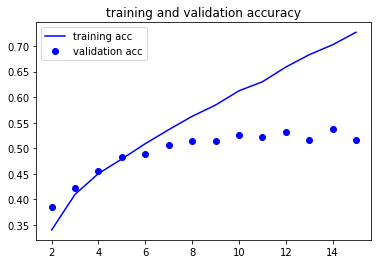

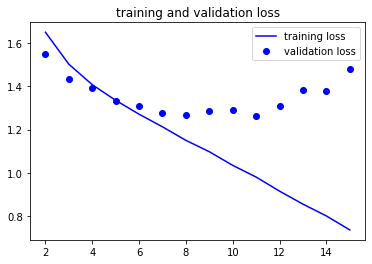

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
# 한층당 W 와 b , 2개씩 있으므로 11개층이라면 22개의 모수 벡터 및 행렬이 출력된다.
W = model.get_weights()

### 2) My VGG16 (Pretrained)

In [0]:
def VGG16(input_shape=(48,48,3), classes=7,include_top=True,pooling=None, weights = None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    # 데이터 size = 48로 하므로써, 전체를 maxpooling 하는 것으로 바꿈.

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(256, activation='relu', kernel_initializer= tf.constant_initializer(W[-6]), bias_initializer= tf.constant_initializer(W[-5]) , name='fc1')(x) # 초기값은     tf.constant_initializer     로 한다!!
        x = Dense(256, activation='relu', kernel_initializer= tf.constant_initializer(W[-4]), bias_initializer= tf.constant_initializer(W[-3]) , name='fc2')(x)
        output = Dense(classes, kernel_initializer=tf.constant_initializer(W[-2]) , bias_initializer= tf.constant_initializer(W[-1]) , activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            output = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            output = GlobalMaxPooling2D()(x)

    # Create model.
    model = Model(img_input, output, name='vgg16')

    # Load weights.
    # 내 모형에서는 쓸모없다. 다만, 나중의 혹시모를 참고를 위해 코드는 남겨놓는다.
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,cache_subdir='models',file_hash='cbe5617147190e668d6c5d5026f83318')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,cache_subdir='models',file_hash='253f8cb515780f3b799900260a226db6')

        model.load_weights(weights_path) #경로에 있는 초기치 weights가져오기

    elif weights is not None:
        model.load_weights(weights)

    return model



In [0]:
model = VGG16(input_shape=(48, 48, 3), classes=7, include_top=True,pooling=None, weights = None)

In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 8)         224       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 8)         584       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 16)        2320      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 16)        0     

In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')


In [0]:
history = model.fit(x_train,y_train,batch_size=64, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 3s 12ms/step - loss: 1.7872 - accuracy: 0.2584 - macro_f1score: 0.0079 - weighted_f1score: 9.1892e-04 - val_loss: 1.7195 - val_accuracy: 0.2895 - val_macro_f1score: 0.0183 - val_weighted_f1score: 0.0019
Epoch 2/100
225/225 [==============================] - 3s 11ms/step - loss: 1.6166 - accuracy: 0.3563 - macro_f1score: 0.0994 - weighted_f1score: 0.0174 - val_loss: 1.5132 - val_accuracy: 0.4060 - val_macro_f1score: 0.1389 - val_weighted_f1score: 0.0264
Epoch 3/100
225/225 [==============================] - 2s 11ms/step - loss: 1.4778 - accuracy: 0.4193 - macro_f1score: 0.1639 - weighted_f1score: 0.0309 - val_loss: 1.4616 - val_accuracy: 0.4291 - val_macro_f1score: 0.1558 - val_weighted_f1score: 0.0281
Epoch 4/100
225/225 [==============================] - 2s 11ms/step - loss: 1.4021 - accuracy: 0.4498 - macro_f1score: 0.1992 - weighted_f1score: 0.0371 - val_loss: 1.4026 - val_accuracy: 0.4433 - val_macro_f1score: 0.2035 - val_weigh

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=64)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

29/29 [==============================] - 0s 5ms/step - loss: 1.3975 - accuracy: 0.5307 - macro_f1score: 0.4359 - weighted_f1score: 0.0721

Accuracy: 0.5307, Macro F1 Score: 0.4359, Weighted F1 Score: 0.0721


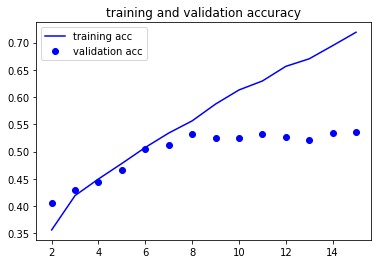

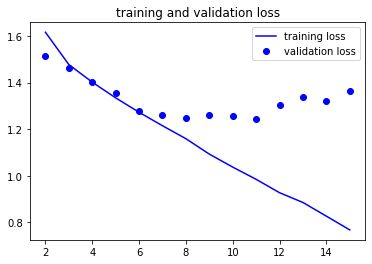

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## 2. My GoogLeNet

### 1) Size = 64

In [0]:
# 기존의 GoogLeNet 개조

# Data Augmentation은 컴퓨터 성능의 한계로 못하기 때문에 변형함.

# 주의 !!!!기본은 모형을 조절하는 것이 아닌, 데이터를 뻥튀기 하는 것임을 늘 잊지말기!!!!

# 다음의 절차로 모형을 개조한다.

# 1. 224의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. stride 2개, pool_size 1개를 변형해서, 최대한 전체적인 모형의 변화를 줄였다.
# 3. 다음과 같이 모형을 재구성한다.


def my_googlenet(input_shape=(64,64,3), classes=7 , weights_path = None ):

    input = Input(input_shape)

    input_pad = ZeroPadding2D(padding=(3, 3))(input)
    conv1_7x7_s2 = Conv2D(8, (7,7), strides=(1,1), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
    # 위에서 stride 2 -> 1로 바꿈.
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

    conv2_3x3_reduce = Conv2D(8, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
    conv2_3x3 = Conv2D(24, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
    conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
    conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
    pool2_helper = PoolHelper()(conv2_zero_pad)
    pool2_3x3_s2 = MaxPooling2D(pool_size=(6,6), strides=(1,1), padding='valid', name='pool2/3x3_s2')(pool2_helper)
    # 위에서 strdie 2 -> 1로 바꿈. , pool_size 3 -> 6 으로 바꿈.  /// 여기까지 완료하면 r x c = 28 x 28 이 됨.

    inception_3a_1x1 = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_reduce = Conv2D(12, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
    inception_3a_3x3 = Conv2D(16, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
    inception_3a_5x5_reduce = Conv2D(2, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
    inception_3a_5x5 = Conv2D(4, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
    inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
    inception_3a_pool_proj = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
    inception_3a_output = Concatenate(axis=-1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

    inception_3b_1x1 = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
    inception_3b_3x3 = Conv2D(24, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
    inception_3b_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
    inception_3b_5x5 = Conv2D(12, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
    inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
    inception_3b_output = Concatenate(axis=-1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

    inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
    pool3_helper = PoolHelper()(inception_3b_output_zero_pad)
    pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(pool3_helper)

    inception_4a_1x1 = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
    inception_4a_3x3 = Conv2D(26, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
    inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
    inception_4a_5x5 = Conv2D(6, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
    inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
    inception_4a_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
    inception_4a_output = Concatenate(axis=-1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

    loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Conv2D(16, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(64, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(rate=0.7)(loss1_fc)
    loss1_classifier = Dense(classes, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('softmax')(loss1_classifier)

    inception_4b_1x1 = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_reduce = Conv2D(14, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
    inception_4b_3x3 = Conv2D(28, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
    inception_4b_5x5_reduce = Conv2D(3, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
    inception_4b_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
    inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
    inception_4b_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
    inception_4b_output = Concatenate(axis=-1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

    inception_4c_1x1 = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
    inception_4c_3x3 = Conv2D(32, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
    inception_4c_5x5_reduce = Conv2D(3, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
    inception_4c_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
    inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
    inception_4c_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
    inception_4c_output = Concatenate(axis=-1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

    inception_4d_1x1 = Conv2D(14, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_reduce = Conv2D(18, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
    inception_4d_3x3 = Conv2D(36, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
    inception_4d_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
    inception_4d_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
    inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
    inception_4d_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
    inception_4d_output = Concatenate(axis=-1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

    loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Conv2D(16, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(8, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(rate=0.7)(loss2_fc)
    loss2_classifier = Dense(classes, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('softmax')(loss2_classifier)

    inception_4e_1x1 = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_reduce = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
    inception_4e_3x3 = Conv2D(40, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
    inception_4e_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
    inception_4e_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
    inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
    inception_4e_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
    inception_4e_output = Concatenate(axis=-1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

    inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)
    pool4_helper = PoolHelper()(inception_4e_output_zero_pad)
    pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(pool4_helper)

    inception_5a_1x1 = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_reduce = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
    inception_5a_3x3 = Conv2D(40, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
    inception_5a_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
    inception_5a_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
    inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
    inception_5a_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
    inception_5a_output = Concatenate(axis=-1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

    inception_5b_1x1 = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
    inception_5b_3x3 = Conv2D(48, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
    inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
    inception_5b_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
    inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
    inception_5b_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
    inception_5b_output = Concatenate(axis=-1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(rate=0.4)(loss3_flat)
    loss3_classifier = Dense(classes, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)

    googlenet = Model(inputs=input, outputs=[loss1_classifier_act,loss2_classifier_act,loss3_classifier_act])


    if weights_path:
        googlenet.load_weights(weights_path)

    # if tf.keras.backend.backend() == 'tensorflow':
    #     # 우리는 tf.keras를 쓰므로, 이상황은 늘 True.
    #     # 또한, 아래의 코드도 시행할 필요가 없다.
    #     # 혹시모를 , 나중의 상황에 대비해 코드만 남겨놓는다.
    #
    #     ops = []
    #     for layer in googlenet.layers:
    #         if layer.__class__.__name__ == 'Conv2D': # layer의 class의 이름이 'conv2d'이면 ~
    #             original_w = K.get_value(layer.kernel)
    #             converted_w = convert_kernel(original_w)
    #             ops.append(tf.assign(layer.kernel, converted_w).op)
    #     K.get_session().run(ops)

    return googlenet



In [0]:
#내 데이터 맞춤형 모형

model = my_googlenet(input_shape=(64, 64, 3), classes=7, weights_path = None)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 64, 64, 8)    1184        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
zero_padding2d_24 (ZeroPadding2 (None, 66, 66, 8)    0           conv1/7x7_s2[0][0]               
____________________________________________________________________________________________

In [0]:
# auxiliary classifier는 regularization의 일종이다. (loss에서 가중치를 주어 계산하는 셈이기 때문.)
model.compile(optimizer='Adam', loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[0.3,0.3,1],
              metrics=['accuracy',macro_f1score,weighted_f1score])

In [0]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')

In [0]:
history = model.fit(x_train_zoom,[y_train,y_train,y_train],batch_size=64, validation_data=(x_valid_zoom,[y_valid,y_valid,y_valid]) , epochs=100,callbacks=[early_stopping])

Epoch 1/100
225/225 [==============================] - 13s 56ms/step - loss: 3.0929 - activation_34_loss: 1.8550 - activation_35_loss: 1.8882 - prob_loss: 1.8309 - activation_34_accuracy: 0.2298 - activation_34_macro_f1score: 8.3470e-05 - activation_34_weighted_f1score: 1.9189e-05 - activation_35_accuracy: 0.2110 - activation_35_macro_f1score: 0.0000e+00 - activation_35_weighted_f1score: 0.0000e+00 - prob_accuracy: 0.2406 - prob_macro_f1score: 0.0000e+00 - prob_weighted_f1score: 0.0000e+00 - val_loss: 2.9931 - val_activation_34_loss: 1.8250 - val_activation_35_loss: 1.8511 - val_prob_loss: 1.8190 - val_activation_34_accuracy: 0.2449 - val_activation_34_macro_f1score: 0.0000e+00 - val_activation_34_weighted_f1score: 0.0000e+00 - val_activation_35_accuracy: 0.2449 - val_activation_35_macro_f1score: 0.0000e+00 - val_activation_35_weighted_f1score: 0.0000e+00 - val_prob_accuracy: 0.2449 - val_prob_macro_f1score: 0.0000e+00 - val_prob_weighted_f1score: 0.0000e+00
Epoch 2/100
225/225 [======

In [0]:
*_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,[y_test,y_test,y_test],batch_size=64)
print("\nFinal Accuracy: {:.4f}, Final Macro F1 Score: {:.4f}, Final Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

In [0]:
import matplotlib.pyplot as plt
acc=history.history['prob_accuracy']
val_acc=history.history['val_prob_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

### 2) Size = 48

In [0]:
# size=64의 googlenet과의 차이점은, AveragePooling2D size가 7에서 5로 바뀌었다는점이다.

def my_googlenet(input_shape=(48,48,3), classes=7 , weights_path = None ):

    input = Input(input_shape)

    input_pad = ZeroPadding2D(padding=(3, 3))(input)
    conv1_7x7_s2 = Conv2D(8, (7,7), strides=(1,1), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
    # 위에서 stride 2 -> 1로 바꿈.
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

    conv2_3x3_reduce = Conv2D(8, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
    conv2_3x3 = Conv2D(24, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
    conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
    conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
    pool2_helper = PoolHelper()(conv2_zero_pad)
    pool2_3x3_s2 = MaxPooling2D(pool_size=(6,6), strides=(1,1), padding='valid', name='pool2/3x3_s2')(pool2_helper)
    # 위에서 strdie 2 -> 1로 바꿈. , pool_size 3 -> 6 으로 바꿈.  /// 여기까지 완료하면 r x c = 28 x 28 이 됨.

    inception_3a_1x1 = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_reduce = Conv2D(12, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
    inception_3a_3x3 = Conv2D(16, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
    inception_3a_5x5_reduce = Conv2D(2, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
    inception_3a_5x5 = Conv2D(4, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
    inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
    inception_3a_pool_proj = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
    inception_3a_output = Concatenate(axis=-1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

    inception_3b_1x1 = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
    inception_3b_3x3 = Conv2D(24, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
    inception_3b_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
    inception_3b_5x5 = Conv2D(12, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
    inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
    inception_3b_output = Concatenate(axis=-1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

    inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
    pool3_helper = PoolHelper()(inception_3b_output_zero_pad)
    pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(pool3_helper)

    inception_4a_1x1 = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
    inception_4a_3x3 = Conv2D(26, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
    inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
    inception_4a_5x5 = Conv2D(6, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
    inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
    inception_4a_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
    inception_4a_output = Concatenate(axis=-1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

    loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Conv2D(16, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(64, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(rate=0.7)(loss1_fc)
    loss1_classifier = Dense(classes, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('softmax')(loss1_classifier)

    inception_4b_1x1 = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_reduce = Conv2D(14, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
    inception_4b_3x3 = Conv2D(28, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
    inception_4b_5x5_reduce = Conv2D(3, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
    inception_4b_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
    inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
    inception_4b_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
    inception_4b_output = Concatenate(axis=-1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

    inception_4c_1x1 = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
    inception_4c_3x3 = Conv2D(32, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
    inception_4c_5x5_reduce = Conv2D(3, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
    inception_4c_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
    inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
    inception_4c_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
    inception_4c_output = Concatenate(axis=-1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

    inception_4d_1x1 = Conv2D(14, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_reduce = Conv2D(18, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
    inception_4d_3x3 = Conv2D(36, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
    inception_4d_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
    inception_4d_5x5 = Conv2D(8, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
    inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
    inception_4d_pool_proj = Conv2D(8, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
    inception_4d_output = Concatenate(axis=-1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

    loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Conv2D(16, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(8, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(rate=0.7)(loss2_fc)
    loss2_classifier = Dense(classes, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('softmax')(loss2_classifier)

    inception_4e_1x1 = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_reduce = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
    inception_4e_3x3 = Conv2D(40, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
    inception_4e_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
    inception_4e_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
    inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
    inception_4e_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
    inception_4e_output = Concatenate(axis=-1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

    inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)
    pool4_helper = PoolHelper()(inception_4e_output_zero_pad)
    pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(pool4_helper)

    inception_5a_1x1 = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_reduce = Conv2D(20, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
    inception_5a_3x3 = Conv2D(40, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
    inception_5a_5x5_reduce = Conv2D(4, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
    inception_5a_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
    inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
    inception_5a_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
    inception_5a_output = Concatenate(axis=-1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

    inception_5b_1x1 = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
    inception_5b_3x3 = Conv2D(48, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
    inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
    inception_5b_5x5 = Conv2D(16, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
    inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
    inception_5b_pool_proj = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
    inception_5b_output = Concatenate(axis=-1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

    pool5_7x7_s1 = AveragePooling2D(pool_size=(5,5), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output) # 여기가 기존 7에서 5로 바뀐다.
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(rate=0.4)(loss3_flat)
    loss3_classifier = Dense(classes, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)

    googlenet = Model(inputs=input, outputs=[loss1_classifier_act,loss2_classifier_act,loss3_classifier_act])


    if weights_path:
        googlenet.load_weights(weights_path)

    # if tf.keras.backend.backend() == 'tensorflow':
    #     # 우리는 tf.keras를 쓰므로, 이상황은 늘 True.
    #     # 또한, 아래의 코드도 시행할 필요가 없다.
    #     # 혹시모를 , 나중의 상황에 대비해 코드만 남겨놓는다.
    #
    #     ops = []
    #     for layer in googlenet.layers:
    #         if layer.__class__.__name__ == 'Conv2D': # layer의 class의 이름이 'conv2d'이면 ~
    #             original_w = K.get_value(layer.kernel)
    #             converted_w = convert_kernel(original_w)
    #             ops.append(tf.assign(layer.kernel, converted_w).op)
    #     K.get_session().run(ops)

    return googlenet



In [0]:
model = my_googlenet(input_shape=(48, 48, 3), classes=7, weights_path = None)

In [0]:
model.summary()

In [0]:
# auxiliary classifier는 regularization의 일종이다. (loss에서 가중치를 주어 계산하는 셈이기 때문.)
model.compile(optimizer='Adam', loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[0.3,0.3,1],
              metrics=['accuracy',macro_f1score,weighted_f1score])

In [0]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 4 , verbose=1,mode='min')

In [0]:
history = model.fit(x_train,[y_train,y_train,y_train],batch_size=64, validation_data=(x_valid,[y_valid,y_valid,y_valid]) , epochs=100,callbacks=[early_stopping , lr_sc])

In [0]:
*_, acc, mac_f1, wei_f1 = model.evaluate(x_test,[y_test,y_test,y_test],batch_size=64)
print("\nFinal Accuracy: {:.4f}, Final Macro F1 Score: {:.4f}, Final Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

In [0]:
import matplotlib.pyplot as plt
acc=history.history['prob_accuracy']
val_acc=history.history['val_prob_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()